### Imports

In [4]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import Audio
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, confusion_matrix,roc_auc_score,recall_score,f1_score, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.models import Sequential

from pyAudioAnalysis import ShortTermFeatures
import opensmile
import xgboost as xgb

### Data Preprocessing

#### Load in output labels and visualize class distribution

In [5]:
# load in output labels
train_csv_file = pd.read_csv('../depression-audio-files/train_split_Depression_AVEC2017.csv')[["Participant_ID", "PHQ8_Binary"]]
dev_csv_file = pd.read_csv('../depression-audio-files/dev_split_Depression_AVEC2017.csv')[["Participant_ID", "PHQ8_Binary"]]
test_csv_file = pd.read_csv('../depression-audio-files/full_test_split.csv')[["Participant_ID", "PHQ_Binary"]].rename(columns={"PHQ_Binary":"PHQ8_Binary"})
all_labels = pd.concat([train_csv_file, dev_csv_file, test_csv_file]).reset_index().drop(columns=["index"])
all_labels.head()

,Participant_ID,PHQ8_Binary
0,303,0
1,304,0
2,305,0
3,310,0
4,312,0


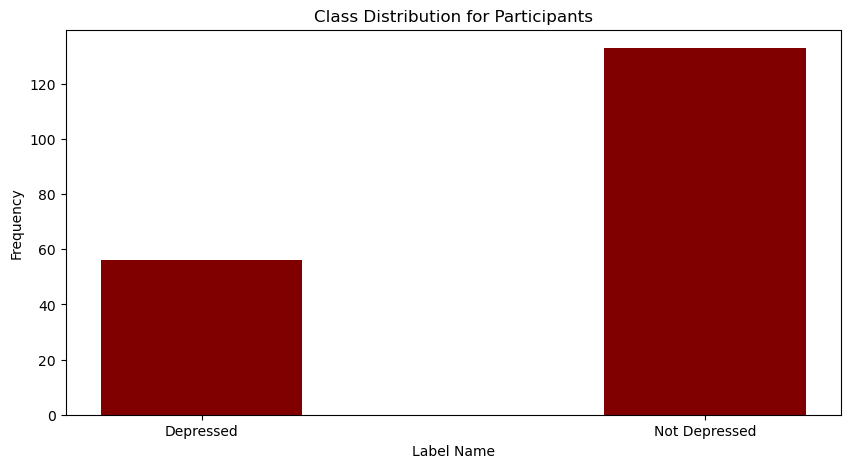

In [6]:
# number of participants labelled as "depressed" vs "nondepressed"

# get the label names and their frequency
all_labels["output_label"] = np.array(["Depressed" if x == 1 else "Not Depressed" for x in all_labels["PHQ8_Binary"]])
x_vals, y_vals = np.unique(all_labels["output_label"], return_counts = True)

# set up figure
fig = plt.figure(figsize = (10, 5))

# create bar plot
plt.bar(x_vals, y_vals, color ='maroon', width=0.4)

# make plot look nice
plt.xlabel("Label Name")
plt.ylabel("Frequency")
plt.title("Class Distribution for Participants")
plt.show()

#### Splice audio into shorter, equal lengthed sample clips and visualize the class distribution of the samples

In [7]:
# function that reads in the wav file and returns a list of the shorter clips
def create_clips(file_path, num_seconds):
    audio,sample_rate = librosa.load(file_path, sr=None) # keep native sample rate
    clip_length = sample_rate * num_seconds # constant for how long a num_seconds clip is

    clips = []
    cur_length = 0
    # create as much num_seconds lengthed clips as possible
    while cur_length + clip_length < len(audio):
        next_clip = audio[cur_length:cur_length+clip_length]
        clips.append(next_clip)
        cur_length += clip_length
    return clips

In [8]:
participants_col = []
audio_col = []
label_col = []

dir_name = '../depression-detect/data/interim'

# iterate through wav files in dir_name and create a segmented wav_file
for folder in os.listdir(dir_name):
    if len(folder) == 4:
        folder_path = os.path.join(dir_name, folder)
        participant_num = np.int64(folder[1:])
        label = all_labels[all_labels["Participant_ID"] == participant_num].reset_index()["output_label"][0]
        for file in os.listdir(folder_path):
            if file.endswith('.wav'):
                file_path = os.path.join(folder_path, file)
                clips = create_clips(file_path, 4)
                audio_col += clips
                label_col += [label for i in range(len(clips))]
                participants_col += [participant_num for i in range(len(clips))]

full_df = pd.DataFrame(
    data = {
        "Participant Number" : participants_col,
        "Audio Timeseries": audio_col,
        "Output Label": label_col}
)
full_df.head()

,Participant Number,Audio Timeseries,Output Label
0,304,"[0.00091552734, 0.0010681152, 0.0009765625, 0....",Not Depressed
1,304,"[-0.002319336, -0.002105713, -0.0020141602, -0...",Not Depressed
2,304,"[-0.0068969727, -0.0072631836, -0.0075683594, ...",Not Depressed
3,304,"[0.00039672852, -0.00033569336, -0.0008239746,...",Not Depressed
4,304,"[-0.015808105, -0.015808105, -0.014190674, -0....",Not Depressed


In [38]:
np.unique(full_df["Output Label"], return_counts = True)

(array(['Depressed', 'Not Depressed'], dtype=object), array([ 7187, 15543]))

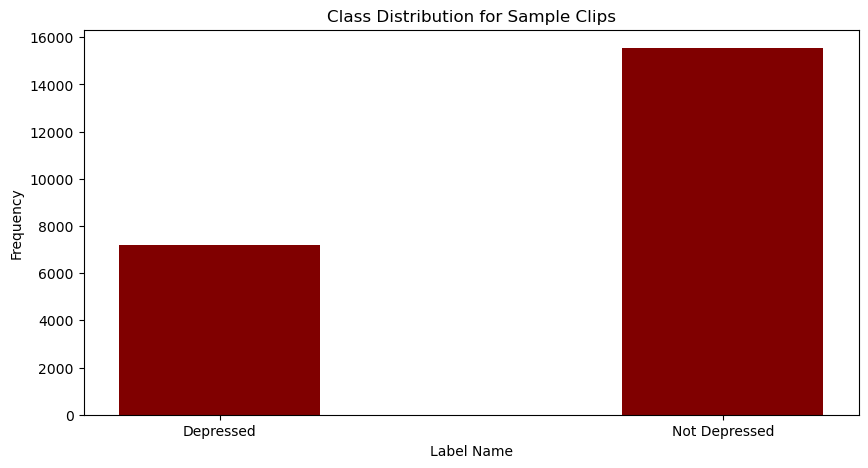

In [33]:
# number of samples labelled as "depressed" vs "nondepressed"

# get the label names and their frequency
x_vals, y_vals = np.unique(full_df["Output Label"], return_counts = True)

# set up figure
fig = plt.figure(figsize = (10, 5))

# create bar plot
plt.bar(x_vals, y_vals, color ='maroon', width=0.4)

# make plot look nice
plt.xlabel("Label Name")
plt.ylabel("Frequency")
plt.title("Class Distribution for Sample Clips")
plt.show()

### Featrure Engineering

#### Create Mel Spectrogram representation of the samples

In [7]:
# create mel spectograms
full_df["Mel Spectrogram"] = full_df["Audio Timeseries"].apply(lambda ts: librosa.feature.melspectrogram(y=ts, sr=16000, n_mels = 512))
full_df

,Participant Number,Audio Timeseries,Output Label,Mel Spectrogram
0,304,"[0.00091552734, 0.0010681152, 0.0009765625, 0....",Not Depressed,"[[0.006687029, 0.055096235, 0.083613485, 0.081..."
1,304,"[-0.002319336, -0.002105713, -0.0020141602, -0...",Not Depressed,"[[0.053209208, 0.013985606, 0.07021931, 0.0481..."
2,304,"[-0.0068969727, -0.0072631836, -0.0075683594, ...",Not Depressed,"[[0.060497828, 0.04650011, 0.025173858, 0.0487..."
3,304,"[0.00039672852, -0.00033569336, -0.0008239746,...",Not Depressed,"[[0.0026677372, 0.02474567, 0.093334176, 0.071..."
4,304,"[-0.015808105, -0.015808105, -0.014190674, -0....",Not Depressed,"[[0.026473274, 0.057223856, 0.026514346, 0.033..."
...,...,...,...,...
22725,340,"[-0.009063721, -0.0087890625, -0.00592041, -0....",Not Depressed,"[[0.008970626, 0.013043981, 0.0012972457, 0.00..."
22726,340,"[-0.0004272461, -0.0015563965, -0.00079345703,...",Not Depressed,"[[0.004804651, 0.013589249, 0.008545222, 0.005..."
22727,340,"[0.00018310547, -0.0012512207, 0.0018920898, -...",Not Depressed,"[[0.00031919483, 0.0038569064, 0.014549127, 0...."
22728,340,"[0.004699707, 0.00015258789, 0.0018310547, 0.0...",Not Depressed,"[[0.007425145, 0.0190512, 0.030070916, 0.13068..."


In [8]:
full_df["Mel Spectrogram"][0].shape

(512, 126)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

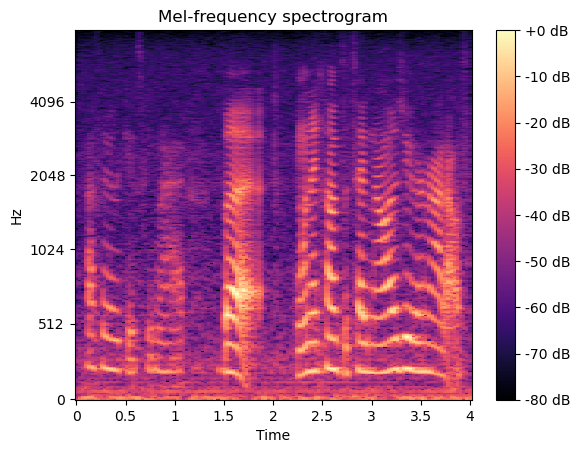

In [9]:
# visualize a mel spectrogram

first_spectrogram = full_df["Mel Spectrogram"].reset_index(drop=True)[0]

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(first_spectrogram, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=16000,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

#### Train, Val, Test Split

In [15]:
def split_data(X, y, split):
    '''Split data into train, validation and test sets.
    '''
    
    # create data splits
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=split[2], random_state=1)

    # compute the size of validation set
    val_size = split[1] / (split[0] + split[1])
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=5)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [9]:
# Define splits
split = (0.8, 0.1, 0.1)

# Create train, val, test sets
X = full_df[["Participant Number", "Audio Timeseries", "Mel Spectrogram"]]
y = full_df[["Output Label"]]

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, split)

# Print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)

print('Shape of val images ', X_val.shape)
print('Shape of val labels ', y_val.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', y_test.shape)

Shape of train images  (18184, 2)
Shape of train labels  (18184, 1)
Shape of val images  (2273, 2)
Shape of val labels  (2273, 1)
Shape of test images  (2273, 2)
Shape of test labels  (2273, 1)


#### Add augmented samples (additional noise) to train set

In [12]:
def add_noise(ts, noise_factor=0.001):
    white_noise = np.random.randn(ts.shape[0]) * noise_factor
    return ts + white_noise

aug_X_train = X_train.copy()
aug_X_train["Audio Timeseries"] = aug_X_train["Audio Timeseries"].apply(add_noise)
aug_X_train["Mel Spectrogram"] = aug_X_train["Audio Timeseries"].apply(lambda ts: librosa.feature.melspectrogram(y=ts, sr=16000, n_mels = 512))
X_train = pd.concat([X_train, aug_X_train])
y_train = pd.concat([y_train, y_train])

print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)

Shape of train images  (36368, 3)
Shape of train labels  (36368, 1)


#### Visualize the original audio vs augmented audio

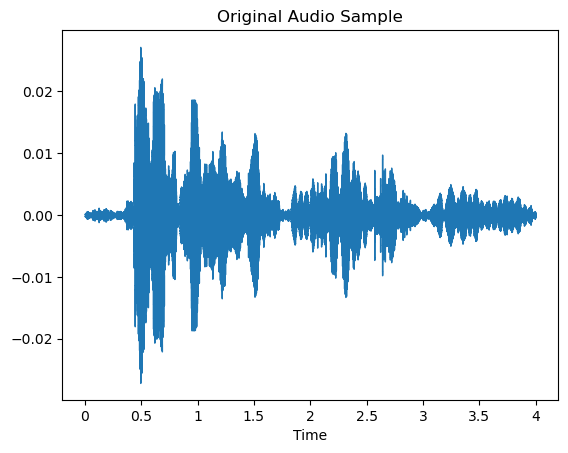

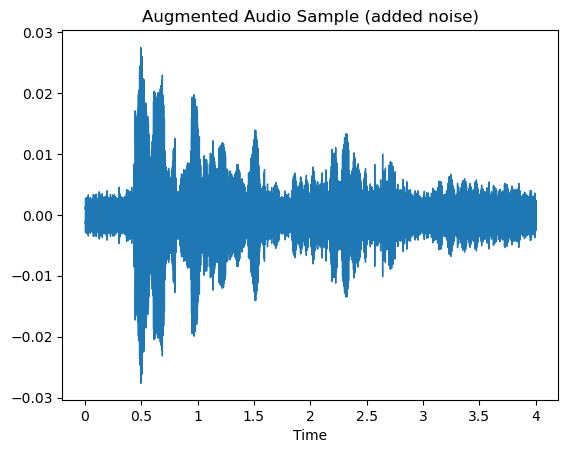

In [13]:
# original audio
sample_wave = X_train["Audio Timeseries"].reset_index(drop=True)[0]

plt.title("Original Audio Sample")
librosa.display.waveshow(sample_wave,sr=16000)
plt.show()

# augmented sample waveform
noise_factor = 0.001
white_noise = np.random.randn(len(sample_wave)) * noise_factor
aug_sample_wave = sample_wave + white_noise

plt.title("Augmented Audio Sample (added noise)")
librosa.display.waveshow(aug_sample_wave,sr=16000)
plt.show()

#### Address Potential Speaker Bias

In [40]:
num_samples_per_part = X_train.groupby(["Participant Number"]).size().sort_values().reset_index()
num_samples_per_part

,Participant Number,0
0,357,33
1,347,38
2,340,38
3,309,44
4,489,45
...,...,...
155,377,214
156,466,221
157,364,259
158,337,259


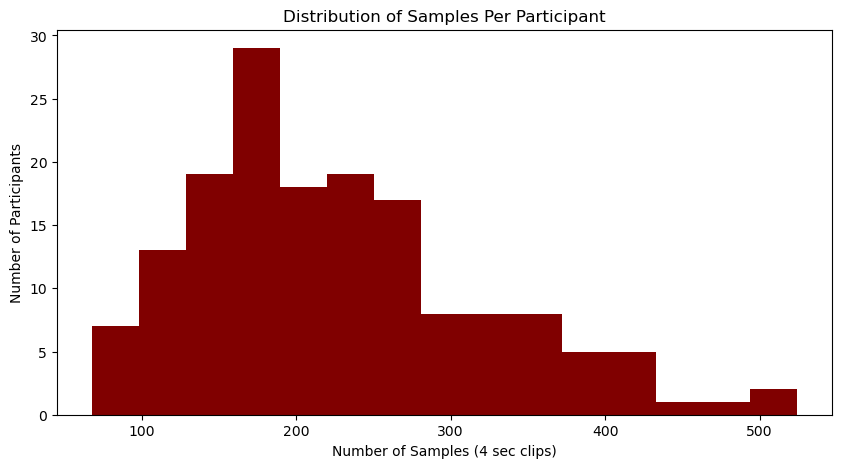

In [14]:
# find participant with least number of clips
num_samples_per_part = X_train.groupby(["Participant Number"]).size().sort_values().reset_index()

# set up figure
fig = plt.figure(figsize = (10, 5))

# create histogram of distribution
plt.hist(num_samples_per_part[0], color="maroon", bins = 15)

# make plot look nice
plt.xlabel("Number of Samples (4 sec clips)")
plt.ylabel("Number of Participants")
plt.title("Distribution of Samples Per Participant")
plt.show()


### Modeling

#### Convert output label to binary

In [ ]:
y_train_labels = y_train["Output Label"]

encoder = LabelEncoder().fit(list(set(y_train_labels))) # fit on unique labels
y_train_encoded_labels = encoder.transform(y_train_labels) # apply to labels array
y_train_encoded_labels_classes = list(encoder.classes_) # store mapping generated by the encoder

y_val_labels = y_val["Output Label"]

encoder = LabelEncoder().fit(list(set(y_val_labels))) # fit on unique labels
y_val_encoded_labels = encoder.transform(y_val_labels) # apply to labels array 
y_val_encoded_labels_classes = list(encoder.classes_) # store mapping generated by the encoder

#### Create 3D numpy array of mel spectrogram values, normalize values

In [ ]:
# reshape to expected dimensions; got changed when putting into dataframe
X_train_melgram = np.array([list(x) for x in np.array(X_train["Mel Spectrogram"])])
X_val_melgram = np.array([list(x) for x in np.array(X_val["Mel Spectrogram"])])

# normalize values
X_train_melgram = np.array([(X - X.min()) / (X.max() - X.min()) for X in X_train_melgram])
X_val_melgram = np.array([(X - X.min()) / (X.max() - X.min()) for X in X_val_melgram])

#### Save processed dataframes / arrays so don't need to reprocess everytime

In [ ]:
X_train.to_csv("X_train")
np.save("X_train_melgram", X_train_melgram)
np.save("y_train_encoded_labels", y_train_encoded_labels)

X_val.to_csv("X_val")
np.save("X_val_melgram", X_val_melgram)
np.save("y_val_encoded_labels", y_val_encoded_labels)

np.save("X_test", X_test)
np.save("y_test", y_test)

#### Load in dataframes

In [139]:
X_train = pd.read_csv("X_train")
X_train.drop(columns=["Unnamed: 0"], inplace=True) # remove the index column that was added

X_train_melgram = np.load("../depression-detect/X_train_melgram.npy")
y_train_encoded_labels = np.load("y_train_encoded_labels.npy")

X_val = pd.read_csv("X_val")
X_val.drop(columns=["Unnamed: 0"], inplace=True) # remove the index column that was added

X_val_melgram = np.load("X_val_melgram.npy")
y_val_encoded_labels = np.load("y_val_encoded_labels.npy")

X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)

In [31]:
# Check the dataframes look okay
print('Shape of X train: ', X_train.shape)
print('Shape of X_train_melgram ', X_train_melgram.shape)
print('Shape of y_train_encoded_labels ', y_train_encoded_labels.shape)

print('Shape of X val: ', X_val.shape)
print('Shape of X_val_melgram ', X_val_melgram.shape)
print('Shape of y_val_encoded_labels ', y_val_encoded_labels.shape)

print('Shape of X test: ', X_test.shape)
print('Shape of y_test ', y_test.shape)

Shape of X train:  (36368, 3)
Shape of X_train_melgram  (36368, 128, 126)
Shape of y_train_encoded_labels  (36368,)
Shape of X val:  (2273, 3)
Shape of X_val_melgram  (2273, 128, 126)
Shape of y_val_encoded_labels  (2273,)
Shape of X test:  (2273, 3)
Shape of y_test  (2273, 1)


#### Create Function to visualize model results

In [36]:
def eval_model(train_preds, y_train, val_preds, y_val, classes):
    print("Train Accuracy: " + str(sum(y_train == train_preds) / len(y_train)))
    print("Validation Accuracy: " + str(sum(y_val == val_preds) / len(y_val)))

    print("\nAUC Score: " + str(roc_auc_score(y_val, val_preds)))

    print("\nF1 Score: " + str(f1_score(y_val, val_preds)))
    print("Recall: " + str(recall_score(y_val, val_preds)))

    cm = confusion_matrix(y_val, val_preds, labels=[0,1])

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.show()

#### Baseline Model: Majority Class Predictor

Train Accuracy: 0.6824131104267488
Validation Accuracy: 0.6792784865816102

AUC Score: 0.5

F1 Score: 0.8090123133350798
Recall: 1.0


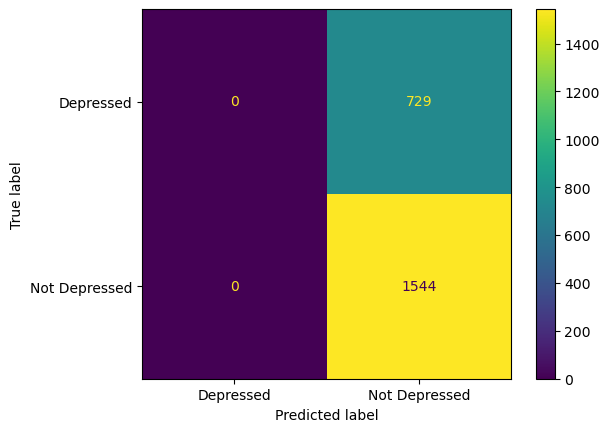

In [37]:
# create prediction for train and val set. only predict 1 / not depressed
majority_train_preds = [1 for i in range(len(y_train_encoded_labels))]
majority_val_preds = [1 for i in range(len(y_val_encoded_labels))]

classes = ["Depressed", "Not Depressed"]

eval_model(majority_train_preds, y_train_encoded_labels, majority_val_preds, y_val_encoded_labels, classes)

#### Create flattened mel spectrograms

In [23]:
flattened_train_spectrograms = X_train_melgram.reshape(X_train_melgram.shape[0], X_train_melgram.shape[1] * X_train_melgram.shape[2])
flattened_val_spectrograms = X_val_melgram.reshape(X_val_melgram.shape[0], X_val_melgram.shape[1] * X_val_melgram.shape[2])

#### Logistic Regression with flattened Mel-Spectrogram

In [35]:
# build model
log_reg_model = models.Sequential()

log_reg_model.add(tf.keras.layers.Flatten())

log_reg_model.add(tf.keras.layers.Dense(
      units=1,
      use_bias=True,
      activation="sigmoid"
  ))

opt = optimizers.legacy.Adam(learning_rate=0.01)
log_reg_model.compile(loss="binary_crossentropy",
                optimizer=opt,
                metrics=['accuracy'])

history = log_reg_model.fit(X_train_melgram, y_train_encoded_labels, epochs=5, batch_size = 32,
                    verbose=1, validation_data=(X_val_melgram, y_val_encoded_labels))

Epoch 1/5
1137/1137 [==============================] - 3s 2ms/step - loss: 0.6146 - accuracy: 0.6874 - val_loss: 0.6783 - val_accuracy: 0.6507
Epoch 2/5
1137/1137 [==============================] - 1s 516us/step - loss: 0.5631 - accuracy: 0.7177 - val_loss: 0.7197 - val_accuracy: 0.6502
Epoch 3/5
1137/1137 [==============================] - 1s 562us/step - loss: 0.5377 - accuracy: 0.7347 - val_loss: 0.7387 - val_accuracy: 0.6419
Epoch 4/5
1137/1137 [==============================] - 1s 514us/step - loss: 0.5182 - accuracy: 0.7466 - val_loss: 0.7540 - val_accuracy: 0.6445
Epoch 5/5
1137/1137 [==============================] - 1s 521us/step - loss: 0.5026 - accuracy: 0.7569 - val_loss: 0.7865 - val_accuracy: 0.6379


72/72 [==============================] - 0s 453us/step
Train Accuracy: 0.7562967443906731
Validation Accuracy: 0.6630004399472064

AUC Score: 0.5198773783378465

F1 Score: 0.7874583795782465
Recall: 0.9190414507772021


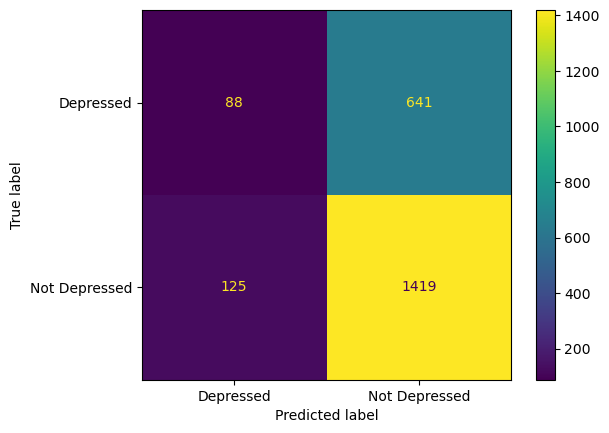

In [41]:
# predict
log_reg_train_preds = log_reg_model.predict(X_train_melgram)
log_reg_val_preds = log_reg_model.predict(X_val_melgram)

# compute predicted output labels based on threshold of 0.5
log_reg_train_preds = [1 if val > 0.35 else 0 for val in log_reg_train_preds]
log_reg_val_preds = [1 if val > 0.35 else 0 for val in log_reg_val_preds]

# evaluate
eval_model(log_reg_train_preds, y_train_encoded_labels, log_reg_val_preds, y_val_encoded_labels, classes)

#### Random Forest Classifier with flattened Mel-Spectrogram

In [ ]:
rf_model = ensemble.RandomForestClassifier(n_estimators=15)
rf_history = rf_model.fit(flattened_train_spectrograms, y_train_encoded_labels)

# predict
rf_train_preds = rf_model.predict(flattened_train_spectrograms)
rf_val_preds = rf_model.predict(flattened_val_spectrograms)

# evaluate
eval_model(rf_train_preds, y_train_encoded_labels, rf_val_preds, y_val_encoded_labels, classes)

#### Convolutional Neural Network

In [ ]:
cnn_model = Sequential()

# first Conv + Maxpool layer
cnn_model.add(Conv2D(128, (3, 3), padding='same', strides=1,
                    input_shape=(128,126,1), activation='relu'))
# model.add(layers.BatchNormalization()) TODO maybe?
cnn_model.add(MaxPooling2D(pool_size=(4, 3), strides=(1, 3)))

# second Conv + Maxpool layer
cnn_model.add(Conv2D(128, (1, 3), padding='valid', strides=1,
            input_shape=(128,126,1), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(1, 3), strides=(1, 3)))

# flatten and dense layer
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))

# output layer
cnn_model.add(Dense(2))
cnn_model.add(Activation('softmax'))

opt = optimizers.Adam(learning_rate=0.01)
cnn_model.compile(loss='sparse_categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

history = cnn_model.fit(X_train_melgram, y_train_encoded_labels, epochs=10, batch_size = 32,
                    verbose=1, validation_data=(X_val_melgram, y_val_encoded_labels))

In [ ]:
# predict 
cnn_train_preds = np.argmax(cnn_model.predict(X_train_melgram),axis=1)
cnn_val_preds = np.argmax(cnn_model.predict(X_val_melgram),axis=1)

# evaluate
eval_model(cnn_train_preds, y_train_encoded_labels, cnn_val_preds, y_val_encoded_labels, encoder.classes_)

### Feature Engineering: OpenSMILE Preprocessing

Using only the spectragram was not getting good results. Let's try using a different feature set. 

In [101]:
sampling_rate = 16000
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)
smile.feature_names

['Loudness_sma3',
 'alphaRatio_sma3',
 'hammarbergIndex_sma3',
 'slope0-500_sma3',
 'slope500-1500_sma3',
 'spectralFlux_sma3',
 'mfcc1_sma3',
 'mfcc2_sma3',
 'mfcc3_sma3',
 'mfcc4_sma3',
 'F0semitoneFrom27.5Hz_sma3nz',
 'jitterLocal_sma3nz',
 'shimmerLocaldB_sma3nz',
 'HNRdBACF_sma3nz',
 'logRelF0-H1-H2_sma3nz',
 'logRelF0-H1-A3_sma3nz',
 'F1frequency_sma3nz',
 'F1bandwidth_sma3nz',
 'F1amplitudeLogRelF0_sma3nz',
 'F2frequency_sma3nz',
 'F2bandwidth_sma3nz',
 'F2amplitudeLogRelF0_sma3nz',
 'F3frequency_sma3nz',
 'F3bandwidth_sma3nz',
 'F3amplitudeLogRelF0_sma3nz']

In [58]:
opensmile_df = pd.DataFrame()

for i in range(len(full_df)):
    audio_ts = smile.process_signal(
        full_df["Audio Timeseries"][i],
        sampling_rate
    )
    feats = audio_ts.reset_index().drop(columns=["end"]).set_index("start")
    feats.index = feats.index.astype(str)
    feats = feats.unstack().to_frame().sort_index(level=1).T
    feats.columns = feats.columns.map('_'.join)
    
    opensmile_df = pd.concat([opensmile_df,feats])

opensmile_df = opensmile_df.reset_index(drop=True)
opensmile_df

,index,F0semitoneFrom27.5Hz_sma3nz_0 days 00:00:00,F1amplitudeLogRelF0_sma3nz_0 days 00:00:00,F1bandwidth_sma3nz_0 days 00:00:00,F1frequency_sma3nz_0 days 00:00:00,F2amplitudeLogRelF0_sma3nz_0 days 00:00:00,F2bandwidth_sma3nz_0 days 00:00:00,F2frequency_sma3nz_0 days 00:00:00,F3amplitudeLogRelF0_sma3nz_0 days 00:00:00,F3bandwidth_sma3nz_0 days 00:00:00,...,logRelF0-H1-A3_sma3nz_0 days 00:00:03.950000,logRelF0-H1-H2_sma3nz_0 days 00:00:03.950000,mfcc1_sma3_0 days 00:00:03.950000,mfcc2_sma3_0 days 00:00:03.950000,mfcc3_sma3_0 days 00:00:03.950000,mfcc4_sma3_0 days 00:00:03.950000,shimmerLocaldB_sma3nz_0 days 00:00:03.950000,slope0-500_sma3_0 days 00:00:03.950000,slope500-1500_sma3_0 days 00:00:03.950000,spectralFlux_sma3_0 days 00:00:03.950000
0,0,0.000000,-201.000000,1264.914551,505.153900,-201.000000,939.587891,1544.775024,-201.000000,802.097717,...,0.000000,0.000000,11.870282,2.027745,10.085790,7.634050,0.000000,-0.024613,0.013578,0.014613
1,0,0.000000,-201.000000,1499.593384,935.950195,-201.000000,1594.369751,1645.894409,-201.000000,908.600891,...,30.394730,-0.075453,34.989738,6.719683,-3.559635,-11.359490,0.673298,0.012563,-0.019012,0.032535
2,0,38.574764,-6.693768,1448.814087,737.737061,-14.786187,1017.293640,1726.909180,-38.727489,784.477539,...,23.991449,5.057047,31.944473,9.994226,2.007056,-5.467661,0.038518,-0.003336,-0.011117,0.016902
3,0,31.191183,-10.063698,1545.126587,543.521179,-22.390503,1288.293457,1495.236328,-32.029263,965.224121,...,21.782770,16.123762,29.539545,21.246565,26.556280,-13.897319,0.577711,0.021546,-0.013585,0.028323
4,0,35.355282,-0.047529,1338.307617,431.350861,-35.097988,1485.449707,1492.592285,-27.922363,593.916809,...,0.000000,0.000000,19.249498,-11.602315,9.792516,9.683018,0.000000,-0.026784,0.005388,0.020590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22725,0,17.029861,-3.888283,1246.393433,410.277069,-4.232802,1046.779541,1306.309448,-24.614655,1030.936401,...,0.000000,0.000000,-8.398011,18.077045,3.957975,4.723042,0.000000,-0.036682,0.024061,0.019144
22726,0,21.759008,-17.149572,1366.744507,754.356506,-25.790985,1292.039551,1649.191406,-28.657633,913.197205,...,0.000000,0.000000,-1.573747,11.522498,29.041010,6.351934,0.000000,-0.013456,0.027999,0.020841
22727,0,0.000000,-201.000000,1090.243164,441.895721,-201.000000,865.304871,1356.142212,-201.000000,817.507019,...,0.000000,0.000000,11.487697,-2.858309,7.454208,3.917596,0.000000,0.023243,0.011787,0.016143
22728,0,0.000000,-201.000000,1123.013306,548.371887,-201.000000,1058.392700,1588.776978,-201.000000,996.872620,...,0.000000,0.000000,29.178122,2.064161,10.817561,-9.173629,0.000000,0.038816,0.015086,0.096641


In [27]:
# save the dataframe as csv file
opensmile_df.to_csv("opensmile_df.csv")

In [7]:
# load back in the dataframe
opensmile_df = pd.read_csv("opensmile_df.csv")
opensmile_df = opensmile_df.drop(columns = ["Unnamed: 0", "index"])
opensmile_df.shape()

(22730, 9902)

In [12]:
# Define splits
split = (0.8, 0.1, 0.1)

# Create train, val, test sets
X = opensmile_df
y = full_df[["Output Label"]]

X_train_opensmile, y_train2, X_val_opensmile, y_val2, X_test_opensmile, y_test2 = split_data(X, y, split)

# Print shapes
print('Shape of train images ', X_train_opensmile.shape)
print('Shape of train labels ', y_train2.shape)

print('Shape of val images ', X_val_opensmile.shape)
print('Shape of val labels ', y_val2.shape)

print('Shape of test images ', X_test_opensmile.shape)
print('Shape of test labels ', y_test2.shape)

Shape of train images  (18184, 9902)
Shape of train labels  (18184, 1)
Shape of val images  (2273, 9902)
Shape of val labels  (2273, 1)
Shape of test images  (2273, 9902)
Shape of test labels  (2273, 1)


In [42]:
y_train_labels = y_train4["Output Label"]

encoder = LabelEncoder().fit(list(set(y_train_labels))) # fit on unique labels
y_train_encoded_labels = encoder.transform(y_train_labels) # apply to labels array
y_train_encoded_labels_classes = list(encoder.classes_) # store mapping generated by the encoder

y_val_labels = y_val4["Output Label"]

encoder = LabelEncoder().fit(list(set(y_val_labels))) # fit on unique labels
y_val_encoded_labels = encoder.transform(y_val_labels) # apply to labels array 
y_val_encoded_labels_classes = list(encoder.classes_) # store mapping generated by the encoder

#### Log Reg with openSMILE features

In [74]:
# build model
log_reg_model = models.Sequential()

log_reg_model.add(tf.keras.layers.Flatten())

log_reg_model.add(tf.keras.layers.Dense(
      units=1,
      use_bias=True,
      activation="sigmoid"
  ))

opt = optimizers.legacy.Adam(learning_rate=0.0001)
log_reg_model.compile(loss="binary_crossentropy",
                optimizer=opt,
                metrics=['accuracy'])

history = log_reg_model.fit(X_train_opensmile, y_train_encoded_labels, epochs=10, batch_size = 32,
                    verbose=1, validation_data=(X_val_opensmile, y_val_encoded_labels))

Epoch 1/10
569/569 [==============================] - 1s 1ms/step - loss: 72.2285 - accuracy: 0.5703 - val_loss: 78.5554 - val_accuracy: 0.4646
Epoch 2/10
569/569 [==============================] - 0s 643us/step - loss: 59.3927 - accuracy: 0.5740 - val_loss: 54.1145 - val_accuracy: 0.6322
Epoch 3/10
569/569 [==============================] - 0s 820us/step - loss: 51.2317 - accuracy: 0.5828 - val_loss: 45.7514 - val_accuracy: 0.6018
Epoch 4/10
569/569 [==============================] - 0s 645us/step - loss: 45.4167 - accuracy: 0.5868 - val_loss: 61.6649 - val_accuracy: 0.6841
Epoch 5/10
569/569 [==============================] - 0s 647us/step - loss: 43.6498 - accuracy: 0.5917 - val_loss: 38.2306 - val_accuracy: 0.6164
Epoch 6/10
569/569 [==============================] - 0s 655us/step - loss: 39.1574 - accuracy: 0.5905 - val_loss: 37.4626 - val_accuracy: 0.6414
Epoch 7/10
569/569 [==============================] - 0s 664us/step - loss: 35.5456 - accuracy: 0.5919 - val_loss: 33.6826 - v

In [ ]:
# predict 
log_reg_smile_preds = np.argmax(cnn_model.predict(X_train_opensmile),axis=1)
log_reg_smile_val_preds = np.argmax(cnn_model.predict(X_train_opensmile),axis=1)

# evaluate
eval_model(log_reg_smile_preds, y_train_encoded_labels, log_reg_smile_val_preds, y_val_encoded_labels, encoder.classes_)

#### Neural Network with OpenSMILE features

In [89]:
nn_model = tf.keras.Sequential([
    tf.keras.Input(shape=(9900,), name='Input'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
opt = optimizers.legacy.Adam(learning_rate=0.1)
nn_model.compile(loss="binary_crossentropy",
                optimizer=opt,
                metrics=['accuracy'])

history = nn_model.fit(X_train_opensmile, y_train_encoded_labels, epochs=10, batch_size = 32,
                    verbose=1, validation_data=(X_val_opensmile, y_val_encoded_labels))

Epoch 1/10
569/569 [==============================] - 4s 6ms/step - loss: 57900.5312 - accuracy: 0.6827 - val_loss: 0.6254 - val_accuracy: 0.6819
Epoch 2/10
569/569 [==============================] - 3s 5ms/step - loss: 5.5521 - accuracy: 0.6842 - val_loss: 0.6255 - val_accuracy: 0.6819
Epoch 3/10
569/569 [==============================] - 3s 5ms/step - loss: 0.6260 - accuracy: 0.6842 - val_loss: 0.6299 - val_accuracy: 0.6819
Epoch 4/10
569/569 [==============================] - 3s 4ms/step - loss: 0.6257 - accuracy: 0.6842 - val_loss: 0.6274 - val_accuracy: 0.6819
Epoch 5/10
569/569 [==============================] - 3s 4ms/step - loss: 0.6250 - accuracy: 0.6842 - val_loss: 0.6326 - val_accuracy: 0.6819
Epoch 6/10
569/569 [==============================] - 2s 4ms/step - loss: 0.6254 - accuracy: 0.6842 - val_loss: 0.6274 - val_accuracy: 0.6819
Epoch 7/10
569/569 [==============================] - 3s 5ms/step - loss: 0.6253 - accuracy: 0.6842 - val_loss: 0.6261 - val_accuracy: 0.6819
Ep

In [ ]:
# predict 
nn_train_preds = np.argmax(nn_model.predict(X_train_opensmile),axis=1)
nn_val_preds = np.argmax(nn_model.predict(X_val_opensmile),axis=1)

# evaluate
classes = ["Depressed", "Not Depressed"]
eval_model(nn_train_preds, y_train_encoded_labels, nn_val_preds, y_val_encoded_labels, classes)

#### LSTM with openSMILE features

Reshaping to array of expected dimensions

In [110]:
feats = smile.process_signal(
        full_df["Audio Timeseries"][0],
        sampling_rate
)
test = feats.to_numpy()
test.shape

(396, 25)

In [114]:
opensmile_feats_list = []

for i in range(len(full_df)):
    audio_ts = smile.process_signal(
        full_df["Audio Timeseries"][i],
        sampling_rate
    )
    opensmile_feats_list.append(feats.to_numpy())

opensmile_array = np.array(opensmile_feats_list)
opensmile_array.shape

(22730, 396, 25)

In [ ]:
# Define splits
split = (0.8, 0.1, 0.1)

# Create train, val, test sets
X = opensmile_array
y = full_df[["Output Label"]]

X_train_opensmile_arr, y_train3, X_val_opensmile_arr, y_val3, X_test_opensmile_arr, y_test3 = split_data(X, y, split)

# Print shapes
print('Shape of train images ', X_train_opensmile_arr.shape)
print('Shape of train labels ', y_train3.shape)

print('Shape of val images ', X_val_opensmile_arr.shape)
print('Shape of val labels ', y_val3.shape)

print('Shape of test images ', X_test_opensmile_arr.shape)
print('Shape of test labels ', y_test3.shape)

Train Model

In [ ]:
lstm_model = tf.keras.Sequential([
    tf.keras.Input(shape=(396,25,), name='Input'),
    tf.keras.layers.LSTM(units=256, activation='relu'),
    tf.keras.layers.LSTM(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
opt = optimizers.Adam(learning_rate=0.1)
lstm_model.compile(loss="binary_crossentropy",
                optimizer=opt,
                metrics=['accuracy'])

history = lstm_model.fit(X_train_opensmile_arr, y_train_encoded_labels, epochs=10, batch_size = 32,
                    verbose=1, validation_data=(X_val_opensmile_arr, y_val_encoded_labels))

In [ ]:
# predict 
lstm_train_preds = np.argmax(lstm_model.predict(X_train_opensmile_arr),axis=1)
lstm_val_preds = np.argmax(lstm_model.predict(X_val_opensmile_arr),axis=1)

# evaluate
classes = ["Depressed", "Not Depressed"]
eval_model(lstm_train_preds, y_train_encoded_labels, lstm_val_preds, y_val_encoded_labels, classes)

#### XGBoost Classifier with openSMILE features

Performed quite well surprisely! Should dig into the most impactful features through looking at the SHAP values of the features and do more analysis on what made this model perform significantly better than the other models.

Train Accuracy: 0.8112626484821821
Validation Accuracy: 0.8134623845138583

AUC Score: 0.7211676259313791

F1 Score: 0.8769587928032502
Recall: 0.9748387096774194


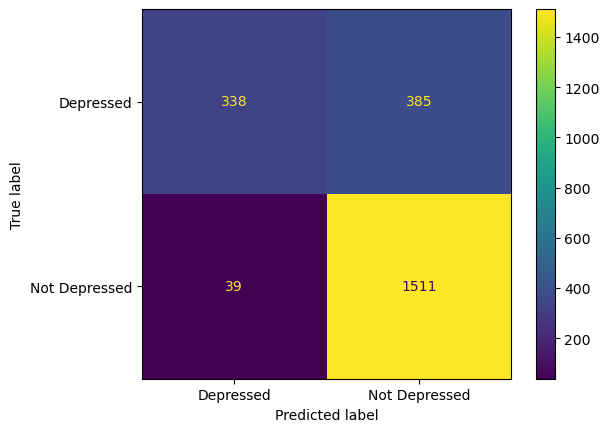

In [64]:
dtrain = xgb.DMatrix(X_train_opensmile, label=y_train_encoded_labels)
dval = xgb.DMatrix(X_val_opensmile, label=y_val_encoded_labels)

# Define the parameters for the XGBoost model
params = {
    'objective': 'binary:hinge', # For binary classification
    'num_class': 1, 
    'eval_metric': 'logloss', # Metric to evaluate the model
    'max_depth': 3, # Maximum depth of a tree
    'eta': 0.3, # Learning rate
    'nthread': 4 # Number of parallel threads used to run xgboost
}

# Train the model
num_round = 20 # Number of boosting rounds
bst = xgb.train(params, dtrain, num_round)

# Make predictions
train_preds = bst.predict(dtrain)
val_preds = bst.predict(dval)

# Calculate the accuracy of the model
eval_model(train_preds, y_train_encoded_labels, val_preds, y_val_encoded_labels, classes)

#### Adaboost with openSMILE features

Train Accuracy: 0.7021557413110426
Validation Accuracy: 0.6814782226132864

AUC Score: 0.5096399411056083

F1 Score: 0.807855626326964
Recall: 0.9819354838709677


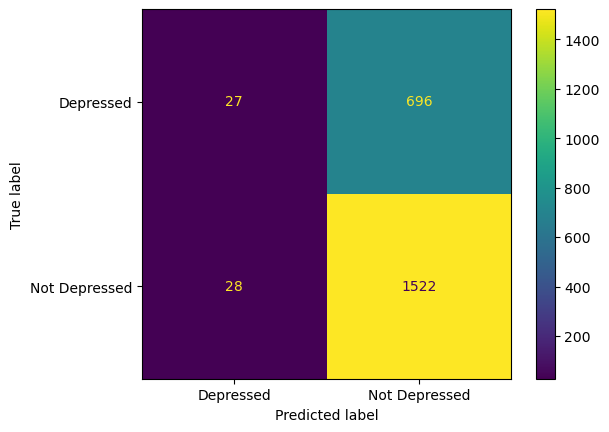

In [136]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Train the model
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=20, learning_rate=0.3)
ada.fit(X_train_opensmile, y_train_encoded_labels)

# Predict
ada_train_preds = ada.predict(X_train_opensmile)
ada_val_preds = ada.predict(X_val_opensmile)

# Calculate the accuracy of the model
eval_model(ada_train_preds, y_train_encoded_labels, ada_val_preds, y_val_encoded_labels, classes)

### Transfer Learning - YAMNET embeddings

#### YAMNET prepreprocessing

In [2]:
import tensorflow_hub as hub

yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [9]:
scores, embeddings2, spectrogram = yamnet_model(full_df["Audio Timeseries"][0])
embeddings2

<tf.Tensor: shape=(8, 1024), dtype=float32, numpy=
array([[0.00624855, 0.35261062, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.06393922, 0.        , 0.0181462 , ..., 0.        , 0.        ,
        0.        ],
       [0.01848277, 0.47270998, 0.08212742, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.03901549, 0.5135804 , 0.34010243, ..., 0.00695705, 0.        ,
        0.        ],
       [0.        , 0.3423146 , 0.00632369, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.59248114, 0.08350924, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)>

In [10]:
yamnet_embs = []

for ts in full_df["Audio Timeseries"]:
    s,emb,l = yamnet_model(ts)
    yamnet_embs.append(emb)

In [60]:
yamnet_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1024)           │     8,389,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,171,973 (96.02 MB)

 Trainable params: 8,390,657 (32.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,781,316 (64.02 MB)

In [13]:
yamnet_embs_arr = np.array(yamnet_embs)

In [16]:
# Define splits
split = (0.8, 0.1, 0.1)

# Create train, val, test sets
X = yamnet_embs_arr
y = full_df[["Output Label"]]

X_train_yamnet, y_train4, X_val_yamnet, y_val4, X_test_yamnet, y_test4 = split_data(X, y, split)

#### Neural Network with YAMNet Embeddings

In [58]:
yamnet_model = tf.keras.Sequential([
    tf.keras.Input(shape=(8,1024,), name='Input'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
opt = optimizers.Adam(learning_rate=0.5)
yamnet_model.compile(loss="binary_crossentropy",
                optimizer=opt,
                metrics=['accuracy'])

history = yamnet_model.fit(X_train_yamnet, y_train_encoded_labels, epochs=10, batch_size = 32, 
                    verbose=1, validation_data=(X_val_yamnet, y_val_encoded_labels))

Epoch 1/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6599 - loss: 778.1606 - val_accuracy: 0.6824 - val_loss: 0.6255
Epoch 2/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.6898 - loss: 0.6688 - val_accuracy: 0.6824 - val_loss: 0.6295
Epoch 3/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6830 - loss: 0.6329 - val_accuracy: 0.6824 - val_loss: 0.6261
Epoch 4/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.6864 - loss: 0.6306 - val_accuracy: 0.6824 - val_loss: 0.6439
Epoch 5/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.6871 - loss: 0.6344 - val_accuracy: 0.6824 - val_loss: 0.6259
Epoch 6/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6827 - loss: 0.6327 - val_accuracy: 0.6824 - val_loss: 0.6317
Epoch 7/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.6826 - loss: 0.6315 - val_accuracy: 0.6824 - val_loss: 0.6316
Epoch 8/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.6867 - loss: 0.6333 

In [ ]:
# predict 
nn_yamnet_train_preds = np.argmax(yamnet_model.predict(X_train_yamnet),axis=1)
nn_yamnet_val_preds = np.argmax(yamnet_model.predict(X_val_yamnet),axis=1)

# evaluate
classes = ["Depressed", "Not Depressed"]
eval_model(nn_yamnet_train_preds, y_train_encoded_labels, nn_yamnet_val_preds, y_val_encoded_labels, classes)

##### Reshape for xgboost

In [31]:
X_val_yamnet.shape

(2273, 8, 1024)

In [40]:
X_train_yamnet = X_train_yamnet.reshape(18184, 8,1024)
X_val_yamnet = X_val_yamnet.reshape(2273, 8,1024)

In [46]:
X_train_yamnet_flat = X_train_yamnet.reshape(18184, 8*1024)
X_val_yamnet_flat = X_val_yamnet.reshape(2273, 8*1024)

Train Accuracy: 0.707765068191817
Validation Accuracy: 0.6845578530576331

AUC Score: 0.5071012358898853

F1 Score: 0.8113654301499605
Recall: 0.9948387096774194


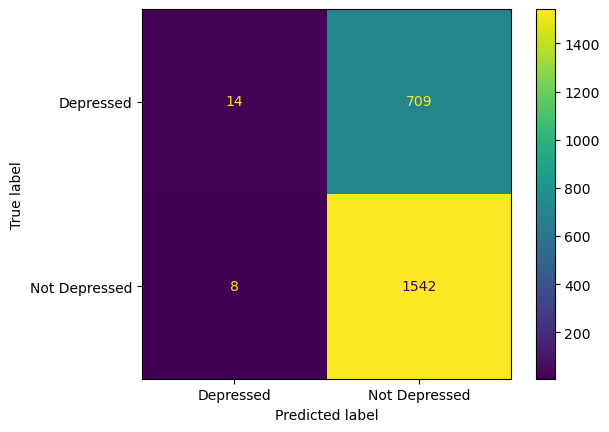

In [56]:
dtrain_yamnet = xgb.DMatrix(X_train_yamnet_flat, label=y_train_encoded_labels)
dval_yamnet = xgb.DMatrix(X_val_yamnet_flat, label=y_val_encoded_labels)

# Define the parameters for the XGBoost model
params = {
    'objective': 'binary:hinge', # For binary classification
    'num_class': 1, 
    'eval_metric': 'logloss', # Metric to evaluate the model
    'max_depth': 5, # Maximum depth of a tree
    'eta': 0.3, # Learning rate
    'nthread': 4 # Number of parallel threads used to run xgboost
}

# Train the model
num_round = 20 # Number of boosting rounds
bst_yamnet = xgb.train(params, dtrain_yamnet, num_round)

# Make predictions
train_preds_yamnet = bst_yamnet.predict(dtrain_yamnet)
val_preds_yamnet = bst_yamnet.predict(dval_yamnet)

# Calculate the accuracy of the model
eval_model(train_preds_yamnet, y_train_encoded_labels, val_preds_yamnet, y_val_encoded_labels, classes)